In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import json
import importlib
import torch
from collections import OrderedDict
import cv2
import numpy as np
import copy

sys.path.append('../')
sys.path.append('../test')



In [2]:
from nnet.py_factory import NetworkFactory
from config import system_configs
from utils import crop_image, normalize_
from external.nms import soft_nms, soft_nms_merge
from coco import apply_detection

In [3]:
cfg_file = 'CenterNet-52-wideeyes'
configs = json.load(open('../config/' + cfg_file + '.json'))
configs["system"]["snapshot_name"] = cfg_file
system_configs.update_config(configs["system"])

system_configs.snapshot_name

'CenterNet-52-wideeyes'

In [4]:
def kp_decode(model, images, K, ae_threshold=0.5, kernel=3):
    with torch.no_grad():
        xs = [x.cuda(non_blocking=True) for x in images]
        detections, center = model(xs[0].unsqueeze(0), ae_threshold=ae_threshold, K=K, kernel=kernel)
    detections = detections.data.cpu().numpy()
    center = center.data.cpu().numpy()
    return detections, center

In [5]:
module_file = "models.{}".format(system_configs.snapshot_name)
module_file = '-'.join(module_file.split('-')[:2])
print(module_file)
nnet_module = importlib.import_module(module_file)

models.CenterNet-52


In [6]:
class FakeDB:
    def __init__(self, config):
        for k, v in config.items():
            self.__setattr__(k, v)

In [7]:
configs['db'].update({'nms_kernel': 3})
db = FakeDB({'configs': configs['db']})

In [8]:
model = nnet_module.model(db)

In [9]:
snapshot = torch.load('/media/db-office-secondary/models/production/centernet_v100/CenterNet-52-wideeyes_800000_with_thresholds.pkl')



In [10]:
opt_thresholds = snapshot['optimal_thresholds']
class_labels = snapshot['class_labels']

In [13]:
weights = OrderedDict()
for k, v in snapshot['state_dict'].items():
    weights[k.replace('module.', '')] = v

In [14]:
model.load_state_dict(weights)
model = model.cuda()

In [15]:
model = model.eval()

In [16]:
image_filename = '/tmp/15652895807184.jpg'
image = cv2.imread(image_filename)

height, width = image.shape[:2]

if max(height, width) > 512:
    ori_scale = max(height, width) / 512.
    image = cv2.resize(image, (int(width/ori_scale), int(height/ori_scale)), cv2.INTER_LINEAR)
else:
    ori_scale = 1

In [17]:
_mean = np.array([0.40789654, 0.44719302, 0.47026115], dtype=np.float32)
_std  = np.array([0.28863828, 0.27408164, 0.27809835], dtype=np.float32)

In [18]:
scales = [1]
scales = [0.6, 1, 1.2, 1.5, 1.8]
merge_bbox = False if len(scales) == 1 else True
top_k = 100 if len(scales) == 1 else 70
# class_labels = sn

nms_algorithm = {"nms": 0,
                 "linear_soft_nms": 1,
                 "exp_soft_nms": 2
                }["exp_soft_nms"]


detections = apply_detection(image, model, scales=scales, decode_func=kp_decode,
                             categories=len(class_labels), top_k=top_k,
                             merge_bbox=False, nms_threshold=db.configs['nms_threshold'],
                             nms_algorithm=nms_algorithm,  weight_exp=10,
                             avg=_mean, std=_std)

In [19]:
for k, v in detections.items():
    detections[k] = v[:4] * ori_scale

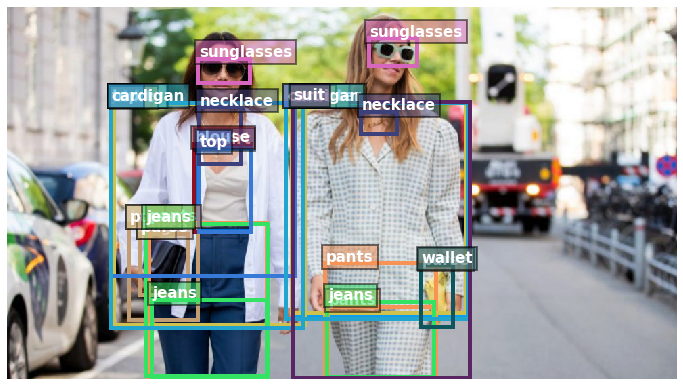

In [20]:
image      = cv2.imread(image_filename)
im         = image[:, :, (2, 1, 0)]
fig, ax    = plt.subplots(figsize=(12, 12))
fig        = ax.imshow(im, aspect='equal')
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
#bboxes = {}      

colours = np.random.rand(80,3)

# for j in range(1, configs['db']['categories'] + 1):
for class_name, j in class_labels.items():
    if j == 0 or detections[j].size == 0:
        continue
    keep_inds = (detections[j][:, -1] >= opt_thresholds[class_name])
    # cat_name  = db.class_name(j)
    for bbox in detections[j][keep_inds]:
        bbox  = bbox[0:4].astype(np.int32)
        xmin     = bbox[0]
        ymin     = bbox[1]
        xmax     = bbox[2]
        ymax     = bbox[3]
        # print(class_name, xmin, ymin, xmax, ymax)
        ax.add_patch(plt.Rectangle((xmin, ymin),xmax - xmin, ymax - ymin, fill=False, edgecolor= colours[j-1],
                     linewidth=4.0))
        ax.text(xmin+1, ymin-3, '{:s}'.format(class_name), bbox=dict(facecolor= colours[j-1], ec='black', lw=2,alpha=0.5),
                fontsize=15, color='white', weight='bold')
